## train 시도 1
- Tensorflow DataGenerator 없이 sklearn split으로 train/test 나눠서 시도
- model save/load 코드 있음
- dataset에서 random하게 뽑아 plt로 시각화해주는 코드 있음
- history에서 loss와 accuray 이력 시각화 해주는 코드 있음

In [ ]:
# execute on colab
from google.colab import drive
drive.mount('/content/drive')
% cd /content/drive/My Drive/supergate/Image_Detector/object_detection
% ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/supergate/Image_Detector/object_detection
01_line_detection.ipynb    images/              restore_img_folder.py
02.img_model_generator.py  make_img_f_list.py   X_test.bin
02_train.py                make_labeled_dir.py  Y_test.bin
03_train.ipynb             model/


In [ ]:
# if you want to use shell command

%%bash
ls

01_line_detection.ipynb
02.img_model_generator.py
02_train.py
03_train.ipynb
images
make_img_f_list.py
make_labeled_dir.py
model
restore_img_folder.py
X_test.bin
Y_test.bin


In [ ]:
# import os
import cv2
import numpy as np
import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
# from tensorflow.python.keras.utils.vis_utils import plot_model
import pandas as pd
import argparse
from sklearn.model_selection import train_test_split
import pickle

def label(df,x_data,y_data):
    #label data
    y_data.append(df[1])
    #image data
    image = cv2.imread('./images/total_img/'+ df[0])
    # 이미지를 BGR 형식에서 RGB 형식으로 변환

    # op1) color image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # op2) gray scale image
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 이미지 축소 (select min pixel)
    image = cv2.resize(image, (480, 640), interpolation=cv2.INTER_AREA)
    # 이미지 배열(RGB 이미지)
    x_data.append(np.array(image))


# 파일 불러오기
def load_label_images(csv_path):
    data = pd.read_csv(csv_path)
    print(data.head())

    #x,y 데이터 만들기
    X = []
    Y = []
    data.apply(lambda df: label(df,X,Y),axis=1)
    X = np.array(X)
    # gray scale image
    # X = np.expand_dims(X,axis=1)
    Y = np.array(Y)
    
    return (X, Y)

X, Y=load_label_images('./images/Flabel_total.csv')

                          0  1
0  2020_0805_104644_076.JPG  0
1  2020_0805_104641_075.JPG  0
2  2020_0805_104414_026.JPG  0
3  2020_0805_105818_224.JPG  0
4  2020_0805_104857_120.JPG  0


In [ ]:
X.shape, Y.shape 

((202, 640, 480, 3), (202,))

In [ ]:
import os 

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=80) #random state history : 100, 80
# test data 따로 보관하기 
try:
    os.remove('X_test.bin')
    os.remove('Y_test.bin')
except:
    pass
with open('X_test.bin','wb') as f:
    pickle.dump(X_test,f)
with open('Y_test.bin','wb') as f:
    pickle.dump(Y_test,f)

##LOAD 할때는 이렇게
# with open('X_test.bin','rb') as f:
#     pickle.load(f)
# with open('Y_test.bin','rb') as f:
#     pickle.load(f)

# 모델정의
model = Sequential()
#CNN-1
model.add(Conv2D(
    # input_shape=X.shape[1:],  #(640, 480, 3) ,color image
    input_shape=X.shape[1:],
    filters=128,
    kernel_size=(8,8),
    strides=(3,3),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(3, 3)))
#cnn-2
model.add(Conv2D(
    filters=64,
    kernel_size=(4,4),
    strides=(2,2),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.02))
#cnn-3
model.add(Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=(2,2),
    padding="same",
    activation='relu',
))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.02))
model.add(Conv2D(32,kernel_size=(2,2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
# fully-connected
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 214, 160, 128)     24704     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 71, 53, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 36, 27, 64)        131136    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 18, 13, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 18, 13, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 3, 32)         

#### save and load model
https://www.tensorflow.org/tutorials/keras/save_and_load


In [ ]:
#compile
model.compile(optimizer='adam',
loss = 'BinaryCrossentropy',
metrics= ['accuracy'],
)

#parameter
batch_size = 50
epochs = 30

OUTPUT_MODEL_DIR = 'model/'
# history = model.fit(X_train, Y_train, 
#                 batch_size=batch_size, epochs=epochs, 
#                 validation_data=(X_test, Y_test),verbose=0)

history=model.fit(X_train, Y_train, epochs=epochs,batch_size=batch_size,verbose=1,validation_data=(X_test, Y_test))
test_loss, test_acc = model.evaluate(X_test, Y_test,batch_size=batch_size,verbose=0)
print(f"validation loss:{test_loss}")
print(f"validation accuracy:{test_acc}")
# 모델 저장
model_file_path = os.path.join(OUTPUT_MODEL_DIR, 'model.h5')
model.save(model_file_path)

Epoch 1/30
3/3 [==============================] - 1s 170ms/step - loss: 0.1723 - accuracy: 0.9645 - val_loss: 0.3401 - val_accuracy: 0.9344
Epoch 2/30
3/3 [==============================] - 0s 78ms/step - loss: 0.1217 - accuracy: 0.9504 - val_loss: 0.7829 - val_accuracy: 0.9344
Epoch 3/30
3/3 [==============================] - 0s 77ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.8892 - val_accuracy: 0.8689
Epoch 4/30
3/3 [==============================] - 0s 77ms/step - loss: 0.0734 - accuracy: 0.9716 - val_loss: 1.1851 - val_accuracy: 0.9180
Epoch 5/30
3/3 [==============================] - 0s 76ms/step - loss: 0.1060 - accuracy: 0.9787 - val_loss: 0.6815 - val_accuracy: 0.9344
Epoch 6/30
3/3 [==============================] - 0s 77ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.3314 - val_accuracy: 0.9344
Epoch 7/30
3/3 [==============================] - 0s 75ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2371 - val_accuracy: 0.9344
Epoch 8/30
3/3 [==========

### load model
new_model = tf.keras.models.load_model('my_model.h5')


In [ ]:
## when kerner restart



# import tensorflow as tf
# import pickle 

# model = tf.keras.models.load_model('model/model.h5')

# ##LOAD 할때는 이렇게
# with open('./X_test.bin','rb') as f:
#     X_test=pickle.load(f)
# with open('./Y_test.bin','rb') as f:
#     Y_test=pickle.load(f)

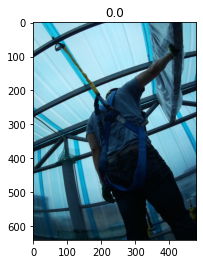

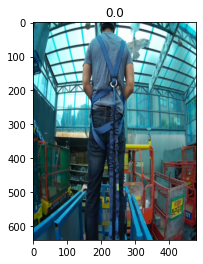

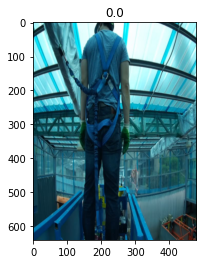

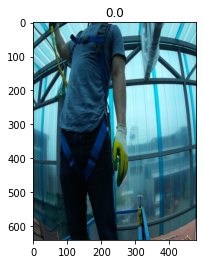

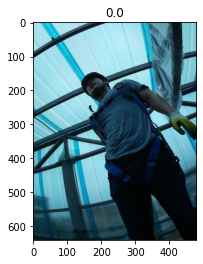

In [ ]:
X_data = X_test
for i in np.random.randint(0,len(X_data)-1, size=5):
    plt.figure()
    plt.imshow(X_data[i])
    result = model.predict(np.expand_dims(X_data[i],axis=0))[0,0]
    plt.title(f"{round(result)}")
    plt.show()


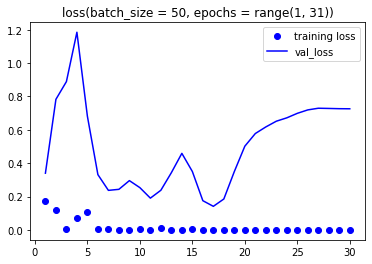

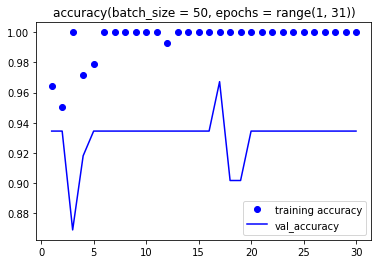

In [ ]:
#include loss, accuracy, val_loss, val_accuracy 
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.plot(epochs,loss,'bo', label='training loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title(f'loss(batch_size = {batch_size}, epochs = {epochs})')
plt.legend()

plt.figure()
plt.plot(epochs,accuracy,'bo', label='training accuracy')
plt.plot(epochs,val_accuracy,'b', label='val_accuracy')
plt.title(f'accuracy(batch_size = {batch_size}, epochs = {epochs})')
plt.legend()
plt.show()

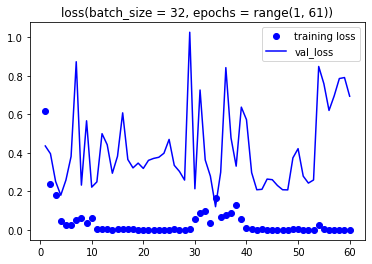

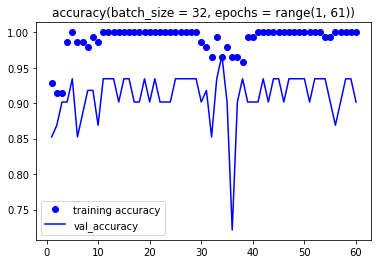

In [ ]:
#include loss, accuracy, val_loss, val_accuracy 
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.plot(epochs,loss,'bo', label='training loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title(f'loss(batch_size = {batch_size}, epochs = {epochs})')
plt.legend()

plt.figure()
plt.plot(epochs,accuracy,'bo', label='training accuracy')
plt.plot(epochs,val_accuracy,'b', label='val_accuracy')
plt.title(f'accuracy(batch_size = {batch_size}, epochs = {epochs})')
plt.legend()
plt.show()

# result
- 결과
    - val acc가 그래도 0.8~0.9는 된다(test set shuffle 할때마다 다르지만)
    - 하지만 체감상 정확도가 0.9처럼 느껴지지 않는다.


- batch_size = 32, epochs = 30
    - accuracy: 1.0000 - val_loss: 0.6174 - val_accuracy: 0.9344
    > train acc 와 val_acc 의 차이가 있는 것으로 보아 dataset이 너무 부족해서 training set에만 너무 특화된 과최적화가 일어난 것 같음

-  batch_size = 32, epochs = 60
    - epoch 를 늘려도 과최적화 현상 동일

- 문제점
    1. 과최적화
    > training set이 적다보니 epoch 아무리 늘려도 testset까지 잘 적용할 수 있는 모델 만들 수 없음

- 개선방안
    - dataset 더 확보
        - label 1인 데이터 더 많이 확보하여 데이터 비대칭 문제 해결
        - 0,1 모두 절대적인 데이터 양이 작아서 (총 200개) 
    - 이미지 전처리
        - cv2.Canny 등으로 경계선 도출하기
        - detect 모델 해서 고리, 사람, 끈 범위는 1인 mask를 만들어서 그것만 살리기
    - 모델 수정
        - 지금은 임의적으로 conv와 dense를 쌓았지만 vgg라던지, autoencoding이라던지 더 발전된 CNN모델 사용 + DNN
        
